# Análisis del perfil crediticio de clientes bancarios



#### Autor: Samuel Arteaga López

En esta práctica vamos a llevar a cabo la tarea de crear dos modelos de inteligencia artificial para una entidad bancaria, cuyo objetivo es el siguiente:
- Prever si se concede el préstamo o no para posibles nuevos solicitantes, cuya variable objetivor será ``loan_status``
- Poder obtener la puntuación del riesgo. Cuya variable target es `risk_score`

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## 1. Carga del CSV

Aquí cargaremos una vista general del dataframe

In [11]:
df = pd.read_csv("csvs/loan_data.csv")
objetivo1 = 'loan_status'
df.head()

,age,gender,education,income,yrs_exp,ownership,amount,purpose,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Echando un ojo de primeras podemos apreciar que los numeros son floats y el resto son datos categoricos excepto `previous_loans` y `loan_status` que funcionan como ``boolean``

Veamos una breve descripción de `loan_status`

In [12]:
print(df[objetivo1].describe())

count    45000.000000
mean         0.222222
std          0.415744
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: loan_status, dtype: float64


## 2. Estudio de valores faltantes

Estructura de los datos, Datos faltantes, Valores únicos

Valores nulos

In [13]:
print(df.isnull().sum())

age                  0
gender               0
education            0
income               0
yrs_exp              0
ownership            0
amount               0
purpose             38
int_rate             0
percent_income       0
cred_hist_length     0
risk_score           0
previous_loans       0
loan_status          0
dtype: int64


Encontramos 38 valores nulos en purpose

Columnas del dataset

In [14]:
print(df.columns)

Index(['age', 'gender', 'education', 'income', 'yrs_exp', 'ownership',
       'amount', 'purpose', 'int_rate', 'percent_income', 'cred_hist_length',
       'risk_score', 'previous_loans', 'loan_status'],
      dtype='object')


Forma (filas, columnas)

In [15]:
print(df.shape)

(45000, 14)


Información general del dataframe

In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               45000 non-null  float64
 1   gender            45000 non-null  object 
 2   education         45000 non-null  object 
 3   income            45000 non-null  float64
 4   yrs_exp           45000 non-null  int64  
 5   ownership         45000 non-null  object 
 6   amount            45000 non-null  float64
 7   purpose           44962 non-null  object 
 8   int_rate          45000 non-null  float64
 9   percent_income    45000 non-null  float64
 10  cred_hist_length  45000 non-null  float64
 11  risk_score        45000 non-null  int64  
 12  previous_loans    45000 non-null  object 
 13  loan_status       45000 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 4.8+ MB
None


Descripción de todas las columnas

In [17]:
print(df.describe(include='all'))

                 age gender education        income       yrs_exp ownership  \
count   45000.000000  45000     45000  4.500000e+04  45000.000000     45000   
unique           NaN      3         5           NaN           NaN         5   
top              NaN   male  Bachelor           NaN           NaN      RENT   
freq             NaN  24841     13399           NaN           NaN     23443   
mean       27.764178    NaN       NaN  8.031905e+04      5.410333       NaN   
std         6.045108    NaN       NaN  8.042250e+04      6.063532       NaN   
min        20.000000    NaN       NaN  8.000000e+03      0.000000       NaN   
25%        24.000000    NaN       NaN  4.720400e+04      1.000000       NaN   
50%        26.000000    NaN       NaN  6.704800e+04      4.000000       NaN   
75%        30.000000    NaN       NaN  9.578925e+04      8.000000       NaN   
max       144.000000    NaN       NaN  7.200766e+06    125.000000       NaN   

              amount    purpose      int_rate  perc

Posibles duplicados del dataframe

In [18]:
print(df.duplicated())

0        False
1        False
2        False
3        False
4        False
         ...  
44995    False
44996    False
44997    False
44998    False
44999    False
Length: 45000, dtype: bool


Como podemos apreciar hay 38 valores nulos en la columna ``purpose``, hay 45000 filas y 14 columnas y no hay duplicados, además se ha adjuntado una breve descripción de cada columna. <br><br>
Dado que `purpose` tiene 38 valores faltantes y es una variable `categorical` hay que transformarla a datos numericos, a continuación borraremos los valores faltantes ya que representan un porcentaje muy bajo en el dataset

In [19]:
df.dropna(inplace=True)
print(df.shape)

(44962, 14)


Como podemos apreciar se han  borrado los valores faltantes

### Visualizacion de datos

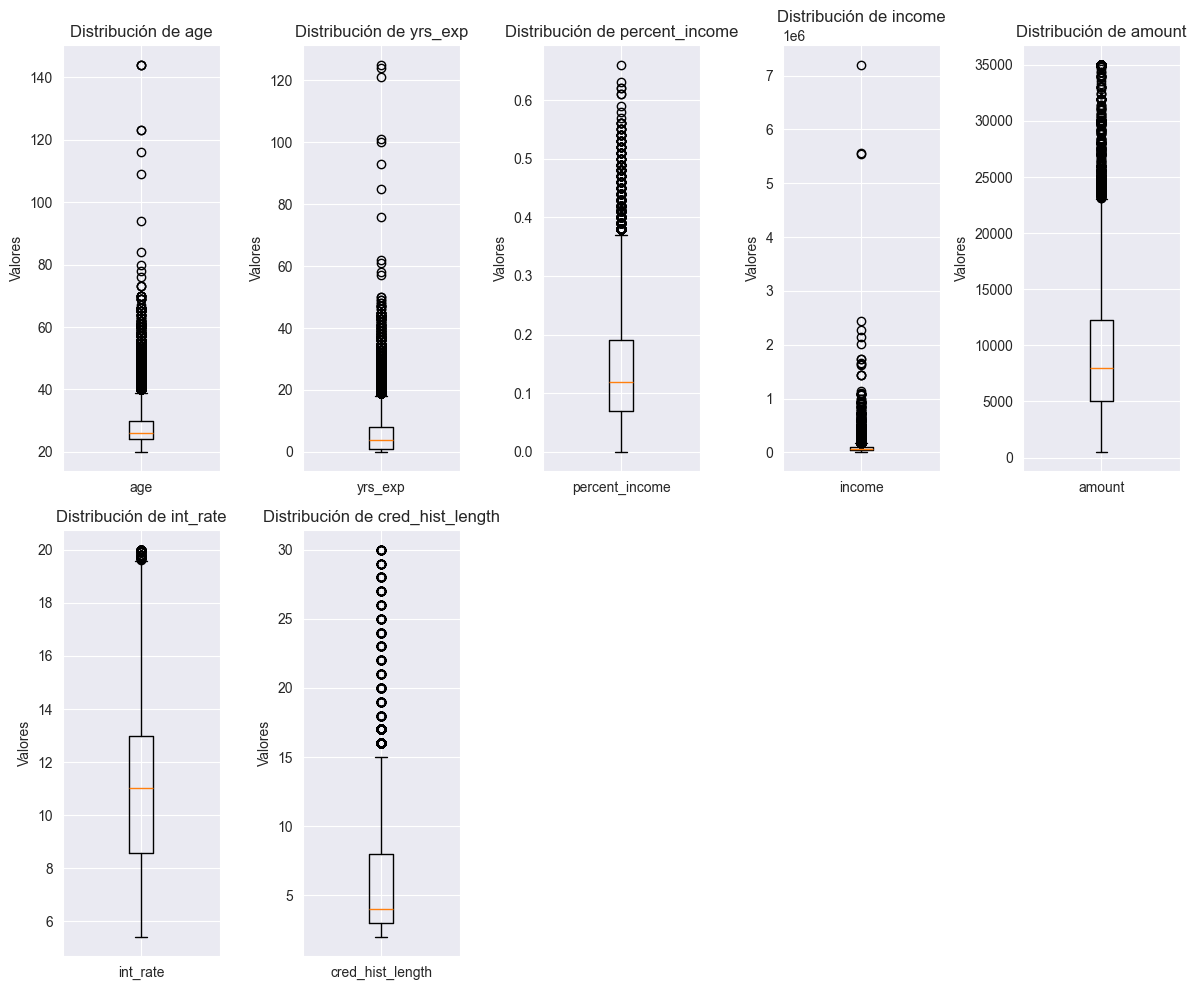

In [20]:
categorias = ['age', 'yrs_exp', 'percent_income', 'income', 'amount', 'int_rate', 'cred_hist_length']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
axes = axes.flatten()
for i, var in enumerate(categorias):
 axes[i].boxplot(df[var], tick_labels=[var])
 axes[i].set_title(f'Distribución de {var}')
 axes[i].set_ylabel('Valores')
for j in range(len(categorias), len(axes)):
 axes[j].axis('off')
plt.tight_layout()
plt.show()


Como podemos apreciar en los gráficos `boxplot` encontramos algunos `outliers`, valores atípicos para los que presenta el fichero, se ha escogido todas las variables númericas excepto las targets `loan_status` y `risk_score` pues no presentan outliers

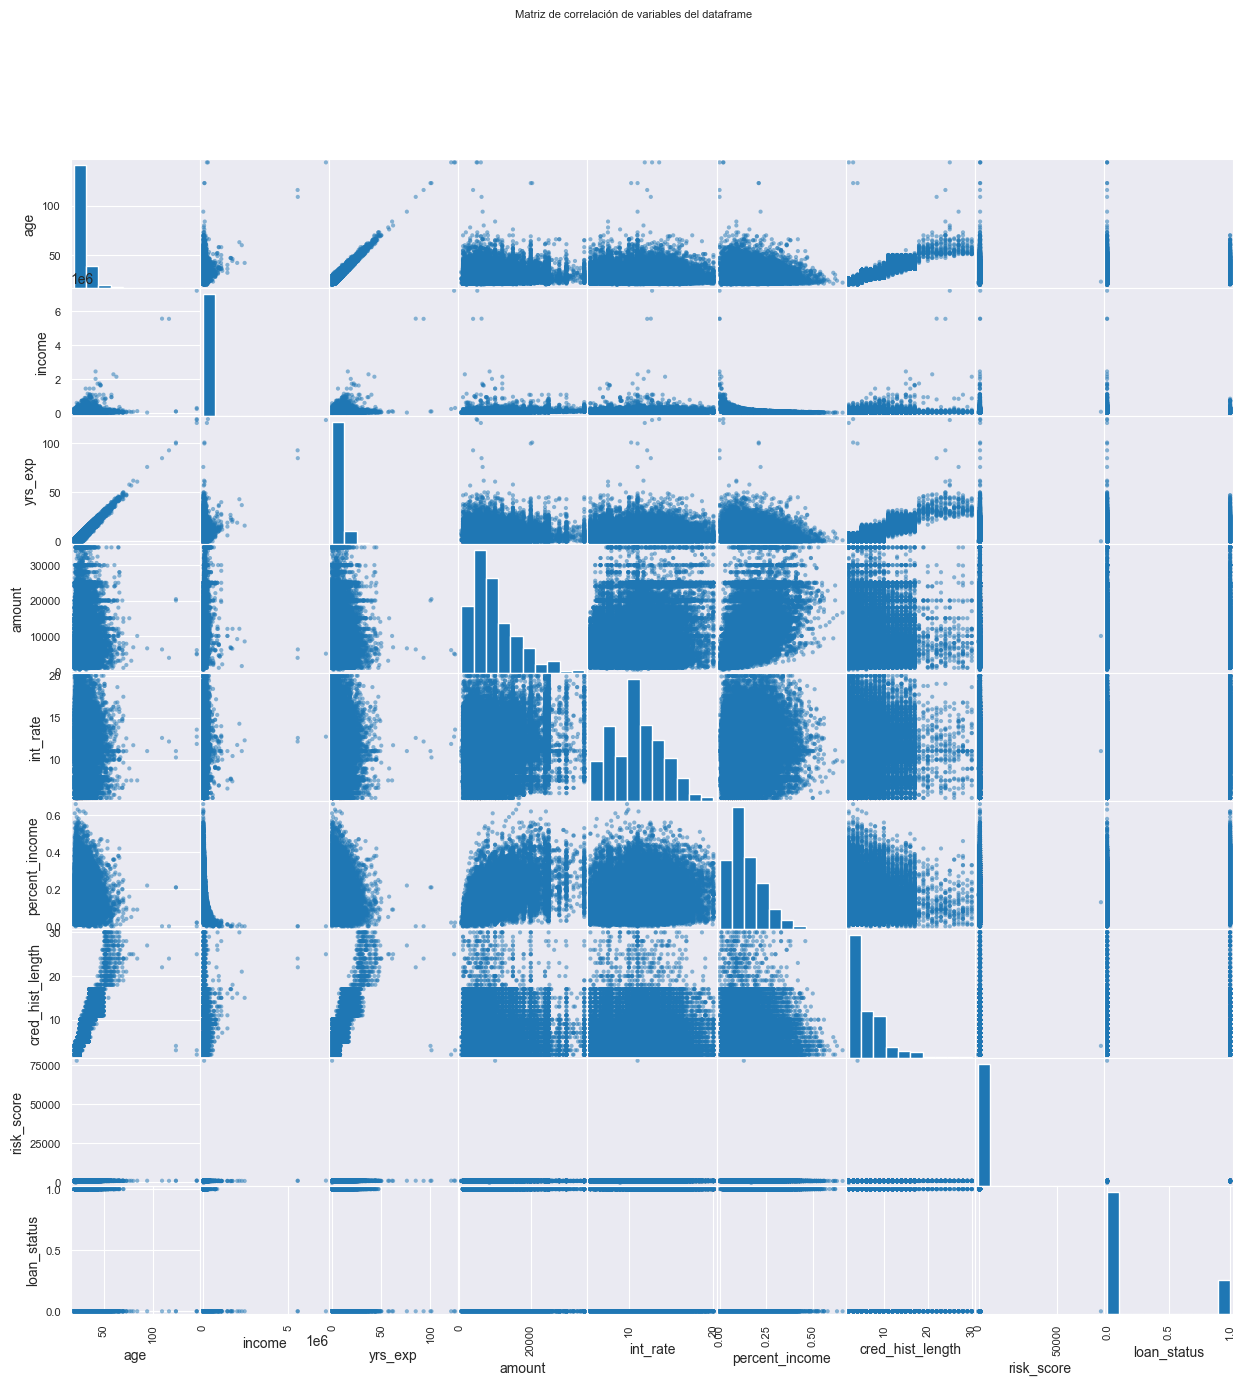

In [21]:
scatter_matrix(df, figsize=(15, 15))
plt.suptitle("Matriz de correlación de variables del dataframe", fontsize=8)
plt.show()

In [22]:
print(df['gender'].value_counts())
df['gender'] = df['gender'].replace("femal", "female")
print(df['gender'].value_counts())

gender
male      24825
female    20136
femal         1
Name: count, dtype: int64
gender
male      24825
female    20137
Name: count, dtype: int64


Aquí hemos realizado un cambio en un valor atípico en la columna genero, donde ponía `femal` se ha cambiado a `female`

In [23]:
# Filtrar y mostrar el registro donde ownership es "OWN"
print(df['ownership'].value_counts())

ownership
RENT        23412
MORTGAGE    18482
OWN          2950
OTHER         117
OWN             1
Name: count, dtype: int64


⚠️ `OWN` está repetido dos veces por lo que deberá de ser tratado ⚠️

In [24]:
# Creamos una columna indicando si hay espacios en blanco
df['espaciosEnBlanco'] = df['ownership'].str.contains(r'\s')

print(df['espaciosEnBlanco'].value_counts())

espaciosEnBlanco
False    44961
True         1
Name: count, dtype: int64


Ya conocemos el motivo de la repetición, en uno de los valores que llevan `OWN` tiene un espacio en blanco, algo como esto ` OWN` procederemos a eliminarlo

In [25]:
df['ownership'] = df['ownership'].str.strip()
df['ownership'].value_counts()

ownership
RENT        23412
MORTGAGE    18482
OWN          2951
OTHER         117
Name: count, dtype: int64

Borramos la columna de los espacios ya que no la necesitamos más

In [26]:
df = df.drop('espaciosEnBlanco', axis=1)
df.head()

,age,gender,education,income,yrs_exp,ownership,amount,purpose,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Podemos comprobar que se ha eliminado correctamente el valor erroneo de la columna

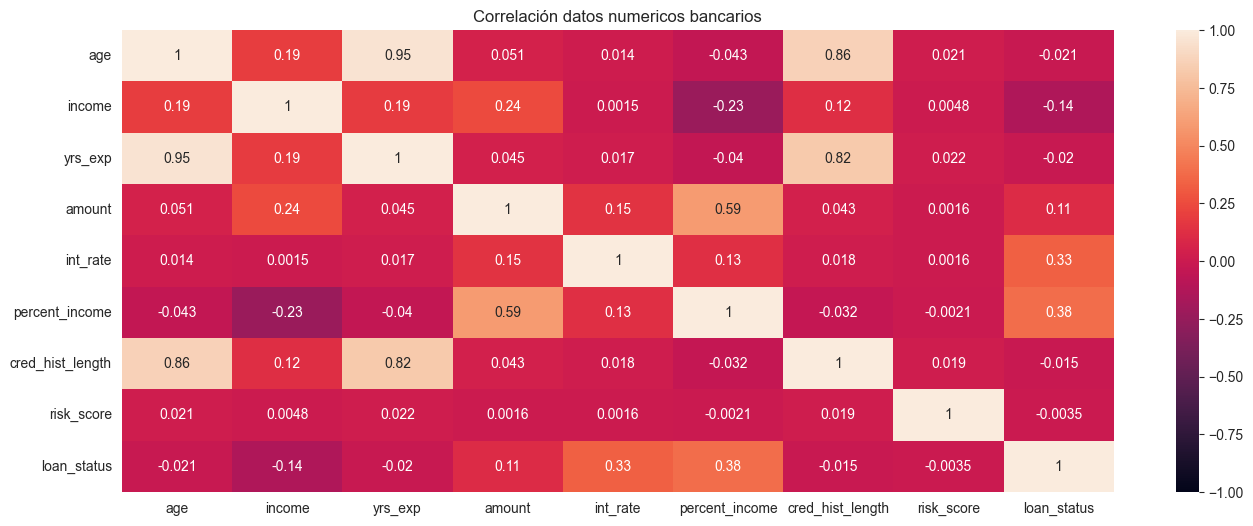

In [27]:
df_numericos = df.select_dtypes(include=np.number)
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_numericos.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlación datos numericos bancarios')
plt.show()

Se ha realizado un mapa de calor para comprobar la relacion entre las variables numericas, estos datos serán tratados más adelante

## 3. Ingenieria de características TODO

Vamos a proceder a cambiar las variables categoricas `gender`, `education`, `ownership`, `purpose`, y `previous_loans`

In [28]:
df.head()

,age,gender,education,income,yrs_exp,ownership,amount,purpose,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [29]:
# Comprobamos que ya no tenemos valores nulos en el dataframe
df.isnull().sum()

age                 0
gender              0
education           0
income              0
yrs_exp             0
ownership           0
amount              0
purpose             0
int_rate            0
percent_income      0
cred_hist_length    0
risk_score          0
previous_loans      0
loan_status         0
dtype: int64

Procederemos a cambiar a tipo numerico las columnas categoricas:
- `Gender`: `female = 0` `male = 1`
- `Previous_loans`: `Yes = 0` `No = 1`

Filtramos los valores que estén por debajo de 100 años

In [30]:
# filtramos la columna age para quedarnos con edades por debajo de 100
df['age'] = df['age'].where(df['age'] < 100 )
df['age'].value_counts()
print(df['age'].isnull().sum())
df.dropna(inplace=True)
print(df.shape)
print(df['age'].isnull().sum())

7
(44955, 14)
0


Al igual que hemos hecho con `age`, filtraremos los valores normales frente a los atipicos en `yrs_exp`

In [31]:
df['yrs_exp'] = df['yrs_exp'].where(df['yrs_exp'] < 100 )
df['yrs_exp'].value_counts()
print(df['yrs_exp'].isnull().sum())
df.dropna(inplace=True)
print(df.shape)
print(df['yrs_exp'].isnull().sum())
df.head()

0
(44955, 14)
0


,age,gender,education,income,yrs_exp,ownership,amount,purpose,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [32]:
df['gender'] = df['gender'].replace(['female', 'male'], [0, 1])
df['previous_loans'] = df['previous_loans'].replace(['Yes', 'No'], [0, 1])

# Instanciar OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Crea un array en vez de una matriz

# Aplicar el encoder a las columnas categóricas
categoricas = ['education', 'ownership', 'purpose']
valores = encoder.fit_transform(df[categoricas])

# Crear un DataFrame con los valores codificados
columnas_codificadas = encoder.get_feature_names_out(categoricas)
df_codificado = pd.DataFrame(valores, columns=columnas_codificadas, index=df.index)

# Concatenar el DataFrame original con las columnas codificadas
df = pd.concat([df.drop(columns=categoricas, axis=1), df_codificado], axis=1)

# Mostrar el DataFrame final
print(df.isnull().sum())

age                          0
gender                       0
income                       0
yrs_exp                      0
amount                       0
int_rate                     0
percent_income               0
cred_hist_length             0
risk_score                   0
previous_loans               0
loan_status                  0
education_Associate          0
education_Bachelor           0
education_Doctorate          0
education_High School        0
education_Master             0
ownership_MORTGAGE           0
ownership_OTHER              0
ownership_OWN                0
ownership_RENT               0
purpose_DEBTCONSOLIDATION    0
purpose_EDUCATION            0
purpose_HOMEIMPROVEMENT      0
purpose_MEDICAL              0
purpose_PERSONAL             0
purpose_VENTURE              0
dtype: int64


C:\Users\ESP\AppData\Local\Temp\ipykernel_16260\3030420232.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace(['female', 'male'], [0, 1])
C:\Users\ESP\AppData\Local\Temp\ipykernel_16260\3030420232.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['previous_loans'] = df['previous_loans'].replace(['Yes', 'No'], [0, 1])


Hemos realizado ingenería de caracteríticas sobre las variables categóricas para proceder a la visualización de las relaciones entre las variables del dataframe, dado que tenemos bastantes

In [33]:
df.head()

,age,gender,income,yrs_exp,amount,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,...,ownership_MORTGAGE,ownership_OTHER,ownership_OWN,ownership_RENT,purpose_DEBTCONSOLIDATION,purpose_EDUCATION,purpose_HOMEIMPROVEMENT,purpose_MEDICAL,purpose_PERSONAL,purpose_VENTURE
0,22.0,0,71948.0,0,35000.0,16.02,0.49,3.0,561,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,21.0,0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,25.0,0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,23.0,0,79753.0,0,35000.0,15.23,0.44,2.0,675,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,24.0,1,66135.0,1,35000.0,14.27,0.53,4.0,586,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


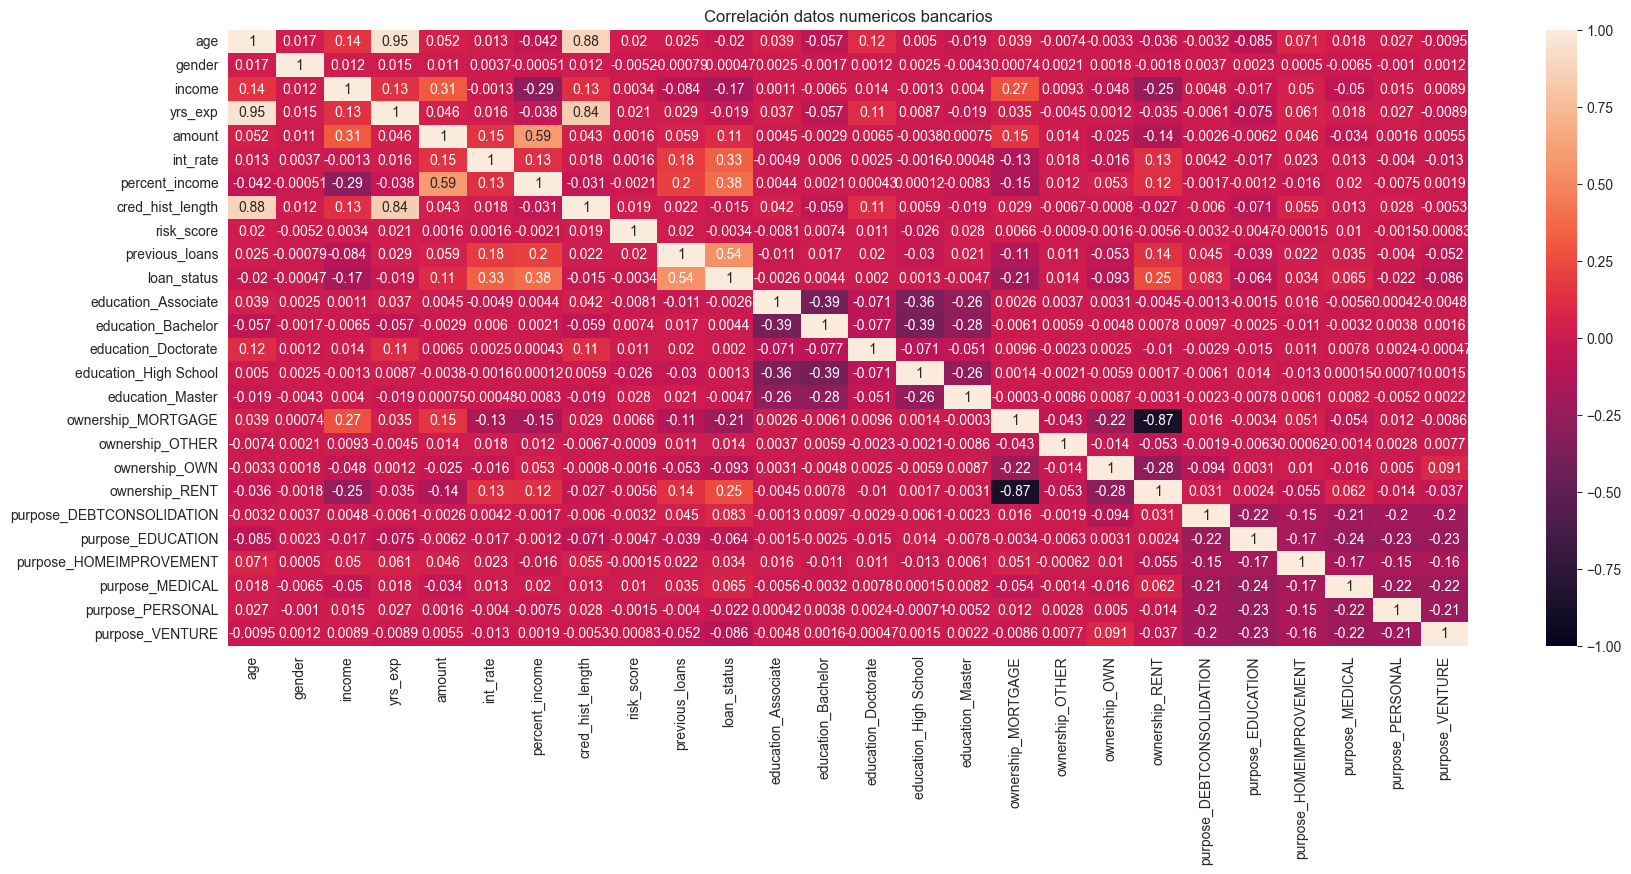

In [34]:
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlación datos numericos bancarios')
plt.show()

In [35]:
print(df.columns)


Index(['age', 'gender', 'income', 'yrs_exp', 'amount', 'int_rate',
       'percent_income', 'cred_hist_length', 'risk_score', 'previous_loans',
       'loan_status', 'education_Associate', 'education_Bachelor',
       'education_Doctorate', 'education_High School', 'education_Master',
       'ownership_MORTGAGE', 'ownership_OTHER', 'ownership_OWN',
       'ownership_RENT', 'purpose_DEBTCONSOLIDATION', 'purpose_EDUCATION',
       'purpose_HOMEIMPROVEMENT', 'purpose_MEDICAL', 'purpose_PERSONAL',
       'purpose_VENTURE'],
      dtype='object')


In [43]:
datos1 = df[["income", "amount", "int_rate", "percent_income", "previous_loans", "ownership_MORTGAGE", "ownership_RENT"]]

# Dividir los datos en entrenamiento y validación
df_train, df_val = train_test_split(datos1, test_size=0.2, random_state=42)

# Entrenar el modelo
modelo_arbol = DecisionTreeRegressor(random_state=42, max_depth=7, min_samples_split=10)
modelo_arbol.fit(df_train, df.loc[df_train.index, "loan_status"])

# Predecir sobre el conjunto de validación
predicciones = modelo_arbol.predict(df_val)

# Calcular el error
error_val = mean_absolute_error(df.loc[df_val.index, "loan_status"], predicciones)
print(f'Métrica para datos de validación: {error_val}')

Métrica para datos de validación: 0.12279639574081487
